X_vectorized.shape: (1756, 51)
X_vectorized array length: 1756
X_transformed.shape: (1756, 52)
X_vectorized.shape: (1172, 51)
X_vectorized array length: 1172
X_transformed.shape: (1172, 52)
cv_results_ :  {'mean_fit_time': array([0.0592854 , 0.05525107, 0.01305218, 0.01323094, 0.01421638,
       0.0120532 , 0.01558604, 0.01811504, 0.02722936, 0.02329683,
       0.02534766, 0.02308488, 0.02131133, 0.02339377, 0.02348547,
       0.02391286, 0.03231072, 0.02400322, 0.02493467, 0.0226666 ,
       0.02287455, 0.02645264, 0.01794696, 0.01224346, 0.01456857,
       0.01594081, 0.01193724, 0.01191874, 0.0115315 , 0.01488414,
       0.01516585, 0.01254487, 0.01060462, 0.01113839, 0.01167755,
       0.0160769 , 0.01311936, 0.01557503, 0.01290464, 0.01705799,
       0.01562991, 0.01610379, 0.01858087, 0.01680326, 0.01312346,
       0.01514902, 0.01396284, 0.01635652, 0.0153749 , 0.01908364,
       0.01861825, 0.01616373, 0.01766262, 0.01978331, 0.01550808,
       0.01834579, 0.0178504 , 0.0171268

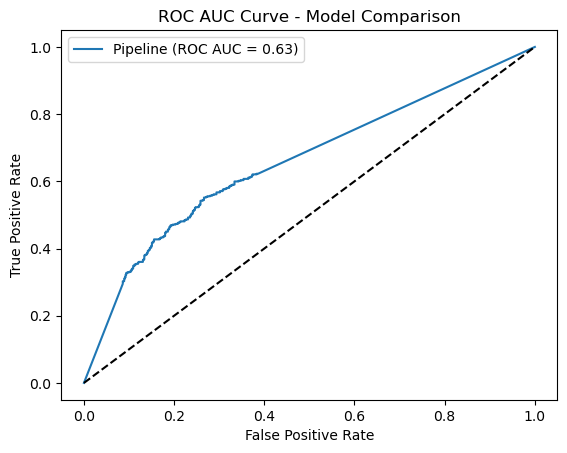

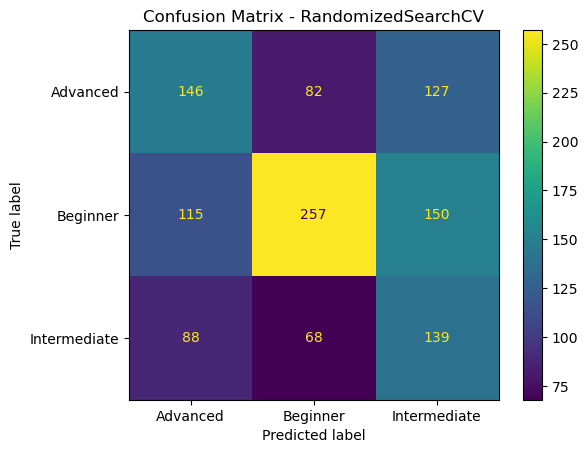


The tunning of KNeighborsClassifier process took: 
	47.36087393760681 seconds 

Finished writing file


In [2]:
import time
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    roc_auc_score,
    roc_curve,
)
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

start = time.time()


def getDataframeXyAndLabelEncoder(data):
    # Convert data into a dataframe
    df = pd.DataFrame(data)

    # Encode the "University" column into numerical values
    label_encoder = LabelEncoder()
    df["University"] = label_encoder.fit_transform(df["University"])

    # Create a separate dataframe for the "University" column
    df_university = pd.DataFrame(df["University"])

    # Generate a new dataset by merging three columns
    X = df["Course_Name"] + " " + df["Course_Description"] + " " + df["Skills"]
    X = pd.DataFrame(X)
    X = X.rename(columns={0: "Name_Description_Skills"})

    # Vectorize the text data using CountVectorizer
    count_vect = CountVectorizer(max_features=51, ngram_range=(1, 2), lowercase=True)
    X_vectorized = count_vect.fit_transform(X["Name_Description_Skills"])

    # Print the shape of the vectorized data
    print("X_vectorized.shape:", X_vectorized.shape)
    print("X_vectorized array length:", len(X_vectorized.toarray()))

    # Convert the vectorized data into a dataframe
    X_vectorized_array = X_vectorized.toarray()
    X_vectorized_df = pd.DataFrame(X_vectorized_array)

    # Rename columns of the dataframe created from CountVectorizer
    X_vectorized_df.columns = X_vectorized_df.columns.astype(str)

    # Add the "University" column back to the dataframe
    X_vectorized_df.insert(0, "University", df_university, True)

    X_transformed = X_vectorized_df

    # Print the shape of the transformed data
    print("X_transformed.shape:", X_transformed.shape)

    # Encode the target labels to numerical values
    label_encoder = LabelEncoder()
    df["Difficulty_Level_Encoded"] = label_encoder.fit_transform(df["Difficulty_Level"])
    y_encoded = df["Difficulty_Level_Encoded"]

    return X_transformed, y_encoded, label_encoder


# read the data from storage
data_from_train_dataset = pd.read_csv("train.csv", sep=";", encoding="latin-1")

# prepare data
X_train_transformed, y_train, label_encoder = getDataframeXyAndLabelEncoder(
    data_from_train_dataset
)

# read the data from storage
data_from_test_dataset = pd.read_csv("test.csv", sep=";", encoding="latin-1")

# prepare data
X_test_transformed, y_test, label_encoder = getDataframeXyAndLabelEncoder(
    data_from_test_dataset
)

# Define the parameter grid for KNeighborsClassifier
param_grid = {
    # Consider two weight options: uniform and distance
    "model__weights": [
        "uniform",
        "distance",
    ],  # range of params for testing
    # will attempt to decide the most appropriate algorithm based on the values passed to fit method. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    "model__algorithm": [
        "auto",
    ],
    # default is 30, so I put a bigger range
    # Vary the leaf size passed to BallTree or KDTree
    "model__leaf_size": range(10, 60),  # range of params for testing
    # Explore two distance metrics: Manhattan distance (p=1) and Euclidean distance (p=2)
    "model__p": [
        1,
        2,
    ],  # range of params for testing
    # Obs.: logistic regression does not have metric parameter.
    # when p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. (docs) https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics
    # Consider distance metrics: Euclidean or manhattan
    "model__metric": [
        "minkowski",
        "manhattan",
    ],  # range of params for testing
    # Number of neighbors to use by default for kneighbors queries
    "model__n_neighbors": range(1, 60),  # range of params for testing
    # Vary the number of parallel jobs (-1 means using all processors, 1 means single job)
    "model__n_jobs": [-1],
}


clf = KNeighborsClassifier()


# to avoid data leakage across folds, perform all the steps of pipeline in each fold
# Create a pipeline with SMOTE oversampling, scaling, and the classifier
pipe = Pipeline(
    steps=[
        ("smote", SMOTE(random_state=42)),
        ("standardscaler", StandardScaler()),
        ("model", clf),
    ]
)

scoring = {
    # The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall
    # f_beta allows to choose a customized beta score, f1_score dont. If I try to pass beta parameter to f1_score, I get the error "f1_score() got an unexpected keyword argument "beta""
    # f1_score: The relative contribution of precision and recall to the F1 score are equal https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    # "f1": make_scorer(f_beta_score, average="weighted", beta=1),
    "f1": make_scorer(f1_score, average="weighted"),
}

# Perform cross-validation for each model using the same folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Otimized to f1 score only
# Perform grid search to find the best parameters
""" searchCV = GridSearchCV(
    clf,
    param_grid,
    scoring=scoring["f1"],
    refit="f1",
    cv=skf,
    error_score="raise",
    n_jobs=-1,
    verbose=1,
) """

# RandomizedSearchCV chosen instead of GridSearchCV because of resources cost (prossessing time)
# Perform RandomizedSearchCV to find the best parameters
searchCV = RandomizedSearchCV(
    pipe,
    param_grid,
    n_iter=512,
    scoring=scoring["f1"],
    refit="f1",
    cv=skf,
    error_score="raise",
    n_jobs=-1,
    random_state=42,
    # verbose=1,
)

# Create a pipeline with SMOTE oversampling, scaling, and the RandomizedSearchCV
pipe_SearchCV = Pipeline(
    steps=[
        ("smote", SMOTE(random_state=42)),
        ("standardscaler", StandardScaler()),
        ("model", searchCV),
    ]
)

pipe_SearchCV.fit(X_train_transformed, y_train)

# Retrieve the results of the RandomizedSearchCV
results = searchCV.cv_results_
print("cv_results_ : ", results)
print("Best Parameters:", searchCV.best_params_)
print("Best F1 Score:", searchCV.best_score_)

# Evaluate the model on the test set
y_pred = pipe_SearchCV.predict(X_test_transformed)
report = classification_report(y_test, y_pred)
print("Classification report: ", report)


def plotRocAucCurve():
    # Get the predicted probabilities for each class on the test set
    y_scores = pipe_SearchCV.predict_proba(X_test_transformed)
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_scores, multi_class="ovr")
    print("\t \t ROC AUC score: ", roc_auc, "\n")

    # Set plot title and labels

    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)

    plt.plot(
        fpr,
        tpr,
        label="{} (ROC AUC = {:.2f})".format(pipe_SearchCV.__class__.__name__, roc_auc),
    )

    plt.title("ROC AUC Curve - Model Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0, 1], [0, 1], "k--")
    # Add a legend
    plt.legend()
    # Show the plot
    plt.show()
    return roc_auc


roc_auc_result = plotRocAucCurve()


def plotConfusionMatrix(y_test, y_pred):
    # Calculate and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot the confusion matrix for each model
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_encoder.classes_
    )
    disp.plot()
    plt.title(f"Confusion Matrix - {searchCV.__class__.__name__}")
    plt.show()
    return cm


confusion_matrix_result = plotConfusionMatrix(y_test, y_pred)


end = time.time()

# # # # # # # # print("RESULTS GridSearchCV \n".join(map(str, results)))

file_path = "results_tunning_KNeighborsClassifier.txt"

# Open the file in write mode
with open(file_path, "w") as file:
    # Write the contents of results array to the file
    file.write("best_params: \n")
    file.write("\t" + str(searchCV.best_params_))
    file.write("\n\n")
    file.write("best_score_: \n")
    file.write("\t" + str(searchCV.best_score_))
    file.write("\n\n")
    file.write("Classification report: \n")
    file.write(report)
    file.write("\n\n")
    file.write("ROC AUC score: \n")
    file.write("\t" + str(roc_auc_result))
    file.write("\n\n")
    file.write("Confusion matrix: \n")
    file.write("\t" + str(confusion_matrix_result[0]) + "\n")
    file.write("\t" + str(confusion_matrix_result[1]) + "\n")
    file.write("\t" + str(confusion_matrix_result[2]))
    file.write("\n\n")
    time_elapsed = str(end - start)
    message = (
        "\nThe tunning of KNeighborsClassifier process took: \n"
        + "\t"
        + time_elapsed
        + " seconds \n"
    )
    file.write(message)
    file.write("\ncv_results: \n")
    file.write(str(searchCV.cv_results_))

print(
    "\nThe tunning of KNeighborsClassifier process took: \n"
    + "\t"
    + time_elapsed
    + " seconds \n"
)
print("Finished writing file")